In [35]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, count, stddev, hour, dayofweek, when, percentile_approx, lit, rand, randn
from pyspark.sql.types import *

spark = SparkSession.builder \
        .appName("Traffic Analysis") \
        .master("local[*]") \
        .getOrCreate()

In [46]:
# csv smoothen data frm flink processing job
smooth_schema = StructType([
    StructField("vehicle_id", StringType(), True),
    StructField("Tracking date", TimestampType(), True),
    StructField("Longitude", DecimalType(10, 6), True),
    StructField("Latitude", DecimalType(10, 6), True),
    StructField("Battery %", DecimalType(5, 2), True),
    StructField("Speed", DecimalType(6, 2), True)
])

In [47]:
# Define schema with data types for raw gps data
schema = StructType([
    StructField("Longitude", DecimalType(10, 6), True),
    StructField("Latitude", DecimalType(10, 6), True),
    StructField("Battery %", DecimalType(5, 2), True),
    StructField("Speed", DecimalType(6, 2), True),
    StructField("Tracking Date", TimestampType(), True),
    StructField("vehicle_id", StringType(), True)
])

In [48]:
smooth_source_df = spark.read.option("header", "true").schema(smooth_schema).csv('smooth-gps/')
source_df = spark.read.option("header", "true").schema(schema).csv('gps-data-raw.csv')

In [51]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import random

In [52]:
source_df.show()

+---------+---------+---------+-----+-------------------+----------+
|Longitude| Latitude|Battery %|Speed|      Tracking Date|vehicle_id|
+---------+---------+---------+-----+-------------------+----------+
|73.055559|18.419432|    99.34|48.36|2024-09-07 00:05:05|      V001|
|73.056258|18.421241|    99.30|49.50|2024-09-07 00:06:59|      V001|
|73.057583|18.420577|    99.27|51.37|2024-09-07 00:08:43|      V001|
|73.058076|18.420809|    99.25|49.57|2024-09-07 00:10:14|      V001|
|73.058069|18.422812|    99.24|51.42|2024-09-07 00:10:54|      V001|
|73.059225|18.421663|    99.22|52.86|2024-09-07 00:12:15|      V001|
|73.058220|18.423726|    99.20|53.24|2024-09-07 00:14:04|      V001|
|73.058603|18.423679|    99.17|52.51|2024-09-07 00:15:07|      V001|
|73.059306|18.424217|    99.15|52.09|2024-09-07 00:17:02|      V001|
|73.060647|18.424118|    99.10|53.83|2024-09-07 00:17:33|      V001|
|73.060732|18.425620|    99.05|52.13|2024-09-07 00:18:30|      V001|
|73.061285|18.424308|    99.03|50.

In [74]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, avg, count, stddev, hour, dayofweek, when, percentile_approx
from pyspark.sql.types import StringType
#import geohash as gh

# Define geohash UDF
def simple_geohash(lat, lon, precision=3):
    """Create a simple geohash by rounding coordinates"""
    if lat is None or lon is None:
        return None
    return f"{round(lat, precision)}_{round(lon, precision)}"

# Register UDF
geohash_udf = F.udf(simple_geohash, StringType())


# 1. Geospatial aggregation with raw data
traffic_patterns = source_df \
    .withColumn("geohash", geohash_udf(col("latitude"), col("longitude"))) \
    .withColumn("hour", hour(col("tracking date"))) \
    .withColumn("day_of_week", dayofweek(col("tracking date"))) \
    .groupBy("geohash", "hour", "day_of_week") \
    .agg(
        avg("speed").alias("avg_speed"),
        count("vehicle_id").alias("vehicle_count"),
        stddev("speed").alias("speed_variance"),
        percentile_approx("speed", 0.5).alias("median_speed")
    ) \
    .withColumn("congestion_level", 
               when(col("avg_speed") < 10, "HIGH")
               .when(col("avg_speed") < 25, "MEDIUM")
               .otherwise("LOW"))



smooth_traffic_patterns = smooth_source_df \
    .withColumn("geohash", geohash_udf(col("latitude"), col("longitude"))) \
    .withColumn("hour", hour(col("tracking date"))) \
    .withColumn("day_of_week", dayofweek(col("tracking date"))) \
    .groupBy("geohash", "hour", "day_of_week") \
    .agg(
        avg("speed").alias("avg_speed"),
        count("vehicle_id").alias("vehicle_count"),
        stddev("speed").alias("speed_variance"),
        percentile_approx("speed", 0.5).alias("median_speed")
    ) \
    .withColumn("congestion_level", 
               when(col("avg_speed") < 10, "HIGH")
               .when(col("avg_speed") < 25, "MEDIUM")
               .otherwise("LOW"))

In [75]:

# Display results
traffic_patterns.show(20, truncate=False)
smooth_traffic_patterns.show(20, truncate=False)
#print(f"Total traffic pattern records: {traffic_patterns.count()}")


+-------------+----+-----------+---------+-------------+-------------------+------------+----------------+
|geohash      |hour|day_of_week|avg_speed|vehicle_count|speed_variance     |median_speed|congestion_level|
+-------------+----+-----------+---------+-------------+-------------------+------------+----------------+
|18.419_73.056|0   |7          |48.360000|1            |NULL               |48.36       |LOW             |
|18.421_73.056|0   |7          |49.500000|1            |NULL               |49.50       |LOW             |
|18.421_73.058|0   |7          |50.470000|2            |1.2727922061357835 |49.57       |LOW             |
|18.422_73.059|0   |7          |52.860000|1            |NULL               |52.86       |LOW             |
|18.423_72.968|0   |7          |25.690000|1            |NULL               |25.69       |LOW             |
|18.423_73.058|0   |7          |51.420000|1            |NULL               |51.42       |LOW             |
|18.424_73.058|0   |7          |53.24

In [76]:
# Show congestion distribution for raw data
traffic_patterns.groupBy("congestion_level").count().show()

+----------------+-----+
|congestion_level|count|
+----------------+-----+
|            HIGH| 1033|
|             LOW| 5445|
|          MEDIUM| 2030|
+----------------+-----+



In [77]:
# Show congestion distribution for raw data
smooth_traffic_patterns.groupBy("congestion_level").count().show()

+----------------+-----+
|congestion_level|count|
+----------------+-----+
|            HIGH|  995|
|             LOW| 5351|
|          MEDIUM| 1923|
+----------------+-----+



### Plotting Raw GPS data

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_patterns(df):
    # Convert traffic patterns to Pandas for visualization
    traffic_pd = df.toPandas()
    
    # Create congestion level heatmap
    plt.figure(figsize=(12, 8))
    
    # Convert congestion level to numeric for heatmap
    congestion_map = {'LOW': 1, 'MEDIUM': 2, 'HIGH': 3}
    traffic_pd['congestion_numeric'] = traffic_pd['congestion_level'].map(congestion_map)
    
    congestion_data = traffic_pd.groupby(['hour', 'day_of_week'])['congestion_numeric'].mean().reset_index()
    congestion_pivot = congestion_data.pivot(index='hour', columns='day_of_week', values='congestion_numeric')
    
    sns.heatmap(congestion_pivot, 
                annot=True, 
                fmt='.2f',
                cmap='RdYlGn_r',
                cbar_kws={'label': 'Congestion Level (1=Low, 2=Medium, 3=High)'},
                xticklabels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
                yticklabels=range(24))
    
    plt.title('Traffic Congestion Heatmap by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.tight_layout()
    plt.show()
    
    # Geographic heatmap of average speed by location
    plt.figure(figsize=(14, 10))
    
    # Extract lat/lon from geohash for geographic visualization
    def decode_simple_geohash(geohash_str):
        if pd.isna(geohash_str):
            return None, None
        try:
            lat_str, lon_str = geohash_str.split('_')
            return float(lat_str), float(lon_str)
        except:
            return None, None
    
    traffic_pd[['lat_decoded', 'lon_decoded']] = traffic_pd['geohash'].apply(
        lambda x: pd.Series(decode_simple_geohash(x))
    )
    
    # Create scatter plot with speed as color
    valid_coords = traffic_pd.dropna(subset=['lat_decoded', 'lon_decoded'])
    
    plt.scatter(valid_coords['lon_decoded'], 
               valid_coords['lat_decoded'], 
               c=valid_coords['avg_speed'], 
               cmap='RdYlGn', 
               s=valid_coords['vehicle_count']*10, 
               alpha=0.7)
    
    plt.colorbar(label='Average Speed (km/h)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographic Distribution of Traffic Patterns\n(Size=Vehicle Count, Color=Average Speed)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("Traffic Pattern Summary:")
    print(f"Total geohash areas: {traffic_pd['geohash'].nunique()}")
    print(f"Peak hour (most vehicles): {traffic_pd.loc[traffic_pd['vehicle_count'].idxmax(), 'hour']}")
    #print(f"Peak day: {traffic_pd.loc[traffic_pd['vehicle_count'].idxmax(), 'day_of_week']}")
    print(f"Average speed across all areas: {traffic_pd['avg_speed'].mean():.2f} km/h")

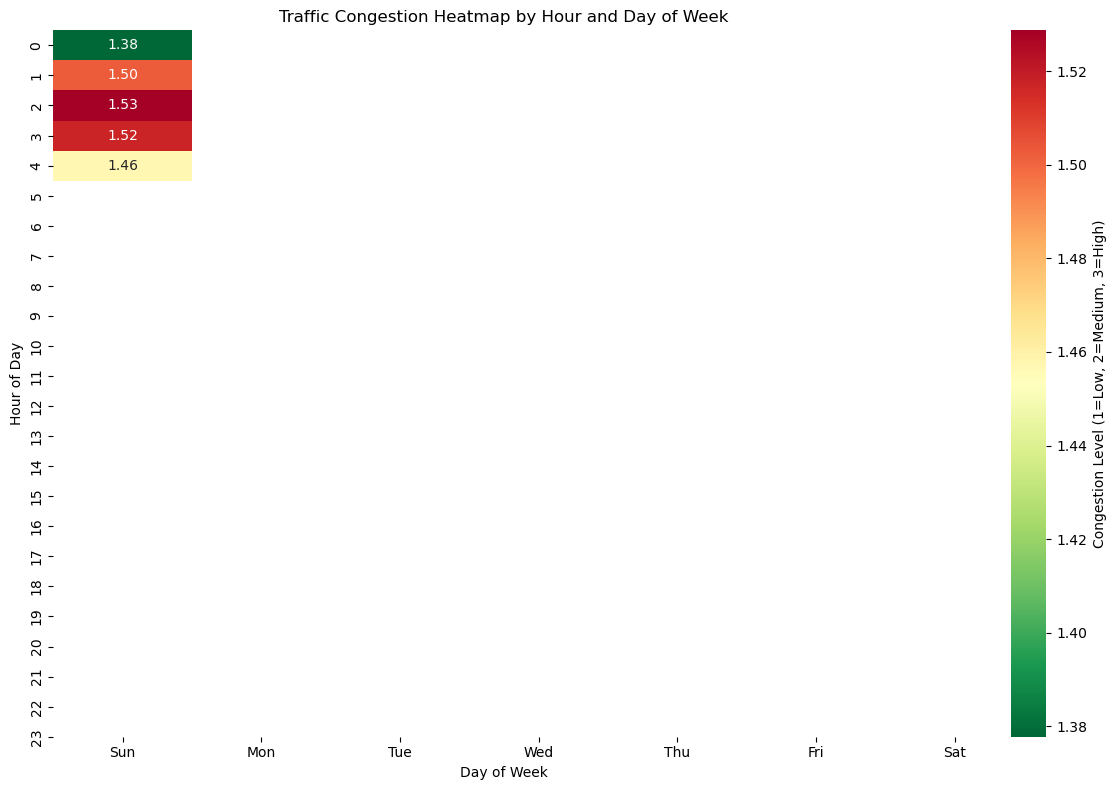

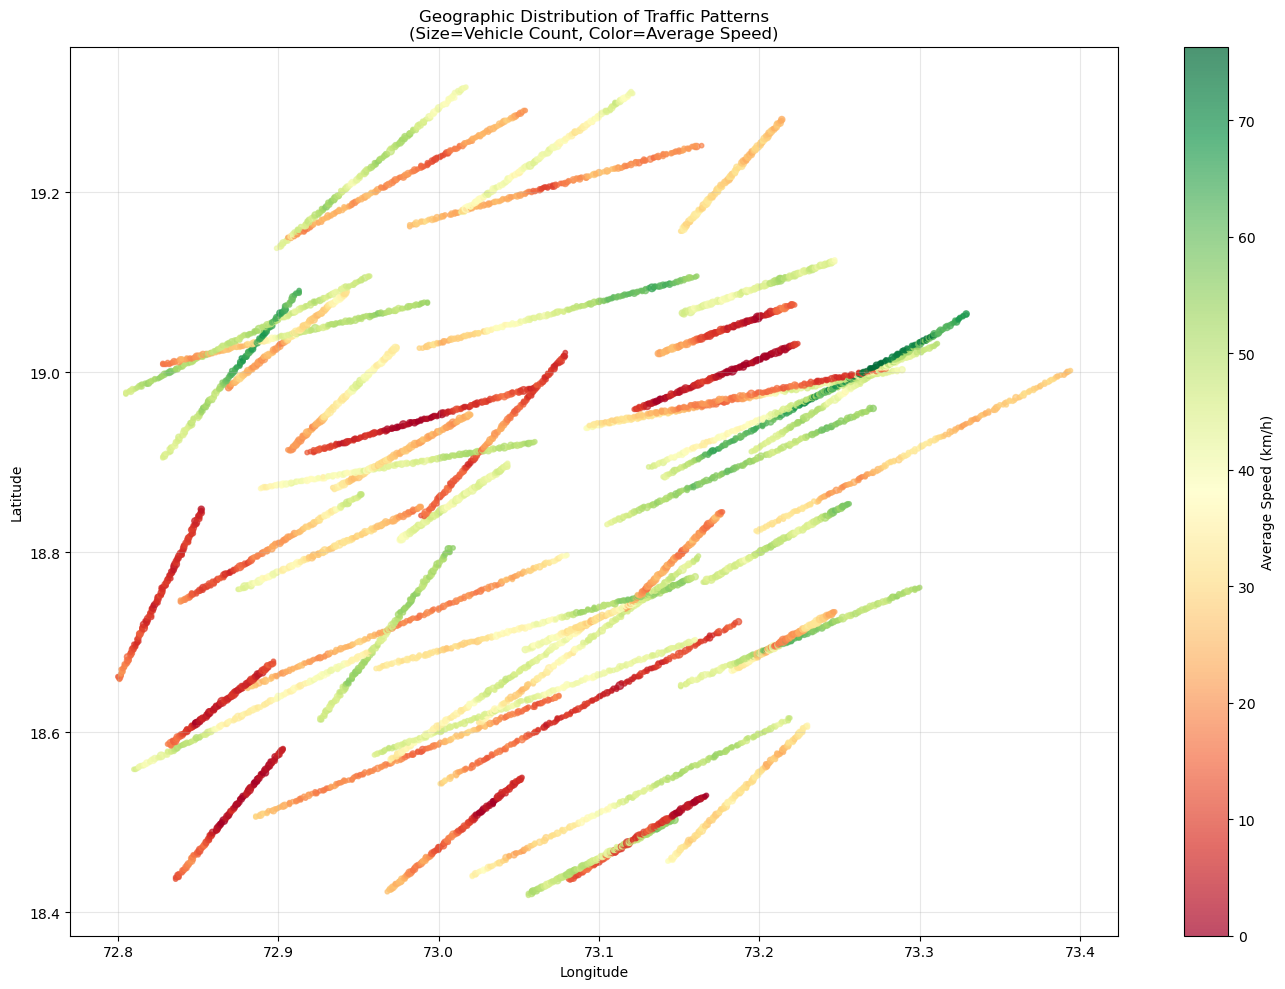

Traffic Pattern Summary:
Total geohash areas: 8426
Peak hour (most vehicles): 2
Average speed across all areas: 32.40 km/h


In [85]:
plot_patterns(traffic_patterns)

### Plotting Smoothened GPS data

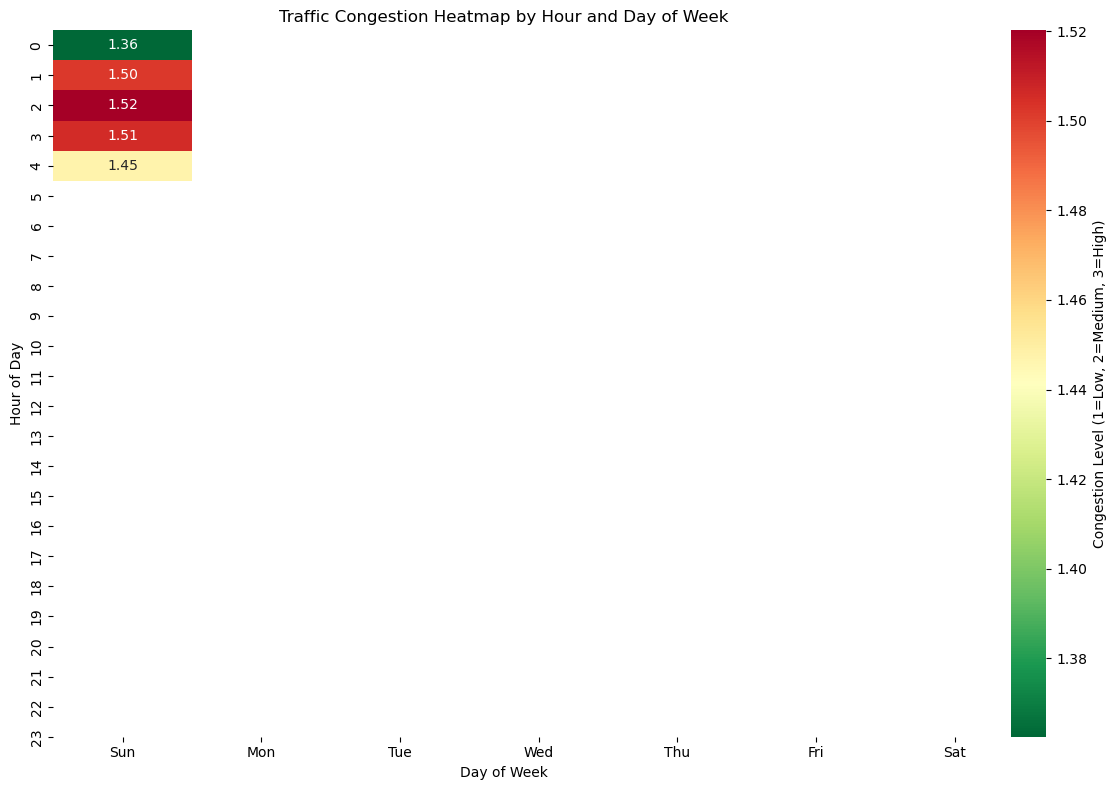

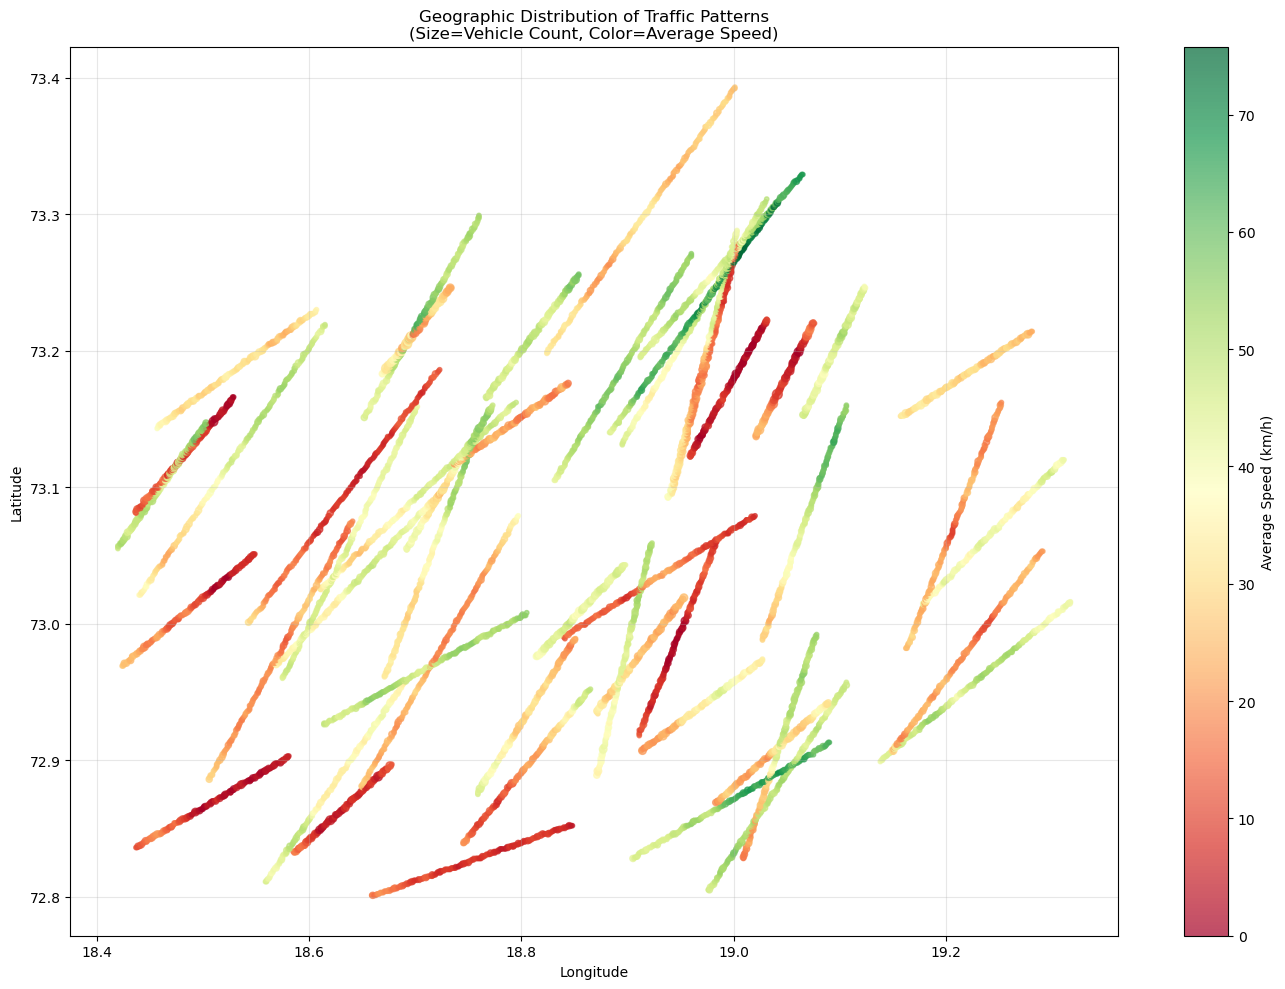

Traffic Pattern Summary:
Total geohash areas: 8187
Peak hour (most vehicles): 1
Average speed across all areas: 32.75 km/h


In [86]:
plot_patterns(smooth_traffic_patterns)